# EDA

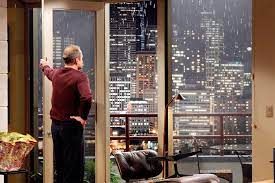

In [45]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

__Importing__

We import pandas and the libaries to connect to the database: 

In [46]:
import pandas as pd
import psycopg2

import os
from dotenv import load_dotenv

We connect to the database: 

In [47]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

In [48]:
# Create connection object conn
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)


We create a cursor: 

In [49]:
cur = conn.cursor()

And we fetch the data query. The query joins the two datasets based on the columns id and house_id which are identical in both datasets: 

In [50]:
cur.execute('SELECT * FROM eda.king_county_house_sales sales INNER JOIN eda.king_county_house_details details ON details.id = sales.house_id')
cur.fetchall()

[(datetime.date(2014, 10, 13),
  221900.0,
  7129300520,
  1,
  7129300520,
  3.0,
  1.0,
  1180.0,
  5650.0,
  1.0,
  None,
  0.0,
  3,
  7,
  1180.0,
  0.0,
  1955,
  0,
  98178,
  47.5112,
  -122.257,
  1340.0,
  5650.0),
 (datetime.date(2014, 12, 9),
  538000.0,
  6414100192,
  2,
  6414100192,
  3.0,
  2.25,
  2570.0,
  7242.0,
  2.0,
  0.0,
  0.0,
  3,
  7,
  2170.0,
  400.0,
  1951,
  19910,
  98125,
  47.721,
  -122.319,
  1690.0,
  7639.0),
 (datetime.date(2015, 2, 25),
  180000.0,
  5631500400,
  3,
  5631500400,
  2.0,
  1.0,
  770.0,
  10000.0,
  1.0,
  0.0,
  0.0,
  3,
  6,
  770.0,
  0.0,
  1933,
  None,
  98028,
  47.7379,
  -122.233,
  2720.0,
  8062.0),
 (datetime.date(2014, 12, 9),
  604000.0,
  2487200875,
  4,
  2487200875,
  4.0,
  3.0,
  1960.0,
  5000.0,
  1.0,
  0.0,
  0.0,
  5,
  7,
  1050.0,
  910.0,
  1965,
  0,
  98136,
  47.5208,
  -122.393,
  1360.0,
  5000.0),
 (datetime.date(2015, 2, 18),
  510000.0,
  1954400510,
  5,
  1954400510,
  3.0,
  2.0,
  1680.

We then save it as a dataframe and get a first hint how our database is structured: 

In [62]:
query_string = "SELECT * FROM eda.king_county_house_sales sales INNER JOIN eda.king_county_house_details details ON details.id = sales.house_id"
df = pd.read_sql(query_string, conn)
df_origin = pd.read_sql(query_string, conn)
df.head()

0         NaN
1       0.000
2       0.000
3       0.000
4       0.000
         ... 
21592   0.000
21593   0.000
21594   0.000
21595     NaN
21596   0.000
Name: waterfront, Length: 21597, dtype: float64

We also check the end of the table: 

In [63]:
df.tail()

,date,price,house_id,id,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21592,2014-05-21,360000.000,263000018,21593,263000018,3.000,2.500,1530.000,1131.000,3.000,...,8,1530.000,0.000,2009,0.000,98103,47.699,-122.346,1530.000,1509.000
21593,2015-02-23,400000.000,6600060120,21594,6600060120,4.000,2.500,2310.000,5813.000,2.000,...,8,2310.000,0.000,2014,0.000,98146,47.511,-122.362,1830.000,7200.000
21594,2014-06-23,402101.000,1523300141,21595,1523300141,2.000,0.750,1020.000,1350.000,2.000,...,7,1020.000,0.000,2009,0.000,98144,47.594,-122.299,1020.000,2007.000
21595,2015-01-16,400000.000,291310100,21596,291310100,3.000,2.500,1600.000,2388.000,2.000,...,8,1600.000,0.000,2004,0.000,98027,47.535,-122.069,1410.000,1287.000
21596,2014-10-15,325000.000,1523300157,21597,1523300157,2.000,0.750,1020.000,1076.000,2.000,...,7,1020.000,0.000,2008,0.000,98144,47.594,-122.299,1020.000,1357.000


Then we get a basic statistical insight how the data is distributed: 

In [64]:
df.describe()

,price,house_id,id,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,19206.000,...,21597.000,21597.000,21145.000,21597.000,17749.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,540296.574,4580474287.771,10799.000,4580474287.771,3.373,2.116,2080.322,15099.409,1.494,0.008,...,7.658,1788.597,291.857,1971.000,836.651,98077.952,47.560,-122.214,1986.620,12758.284
std,367368.140,2876735715.748,6234.661,2876735715.748,0.926,0.769,918.106,41412.637,0.540,0.087,...,1.173,827.760,442.491,29.375,4000.111,53.513,0.139,0.141,685.230,27274.442
min,78000.000,1000102.000,1.000,1000102.000,1.000,0.500,370.000,520.000,1.000,0.000,...,3.000,370.000,0.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,322000.000,2123049175.000,5400.000,2123049175.000,3.000,1.750,1430.000,5040.000,1.000,0.000,...,7.000,1190.000,0.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,450000.000,3904930410.000,10799.000,3904930410.000,3.000,2.250,1910.000,7618.000,1.500,0.000,...,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.231,1840.000,7620.000
75%,645000.000,7308900490.000,16198.000,7308900490.000,4.000,2.500,2550.000,10685.000,2.000,0.000,...,8.000,2210.000,560.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,7700000.000,9900000190.000,21597.000,9900000190.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,...,13.000,9410.000,4820.000,2015.000,20150.000,98199.000,47.778,-121.315,6210.000,871200.000


Furthermore, we look whoch type of data is loaded in every column: 

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   id             21597 non-null  int64  
 5   bedrooms       21597 non-null  float64
 6   bathrooms      21597 non-null  float64
 7   sqft_living    21597 non-null  float64
 8   sqft_lot       21597 non-null  float64
 9   floors         21597 non-null  float64
 10  waterfront     19206 non-null  float64
 11  view           21534 non-null  float64
 12  condition      21597 non-null  int64  
 13  grade          21597 non-null  int64  
 14  sqft_above     21597 non-null  float64
 15  sqft_basement  21145 non-null  float64
 16  yr_built       21597 non-null  int64  
 17  yr_renovated   17749 non-null  float64
 18  zipcod

__Data Cleaning__

We now check for duplicates: 

In [66]:
df.duplicated().value_counts()

False    21597
Name: count, dtype: int64

No duplicates found. Now we check whether all datatype is as expected: 

In [67]:
df.dtypes

date              object
price            float64
house_id           int64
id                 int64
id                 int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

Specifically checking the type of date:

In [68]:
type(df['date'][0])

datetime.date

Date is in the correct data type. But the column year_renovated is a float and should be an integer. 

In [69]:
df['yr_renovated'] = df['yr_renovated'].astype(int)
type(df['yr_renovated'])

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

It seems that it is impossible to convert the datatype while there are missing values (which there are). We keep this in mind and transform the datatype later while the cleaning process. 
But there are two columns named the same. So we rename the ambigious column 'id' to index: 

In [70]:
df.columns.values[3] = 'index'
df.columns

Index(['date', 'price', 'house_id', 'index', 'id', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Now we check for missing values: 

In [71]:
import missingno as msno

df.isna().sum()

date                0
price               0
house_id            0
index               0
id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Now we want to know how large the percentage of missing values is: 

In [72]:
error_waterfront = round(df['waterfront'].isna().sum()/df['waterfront'].shape[0]*100, 1)
error_view = round(df['view'].isna().sum()/df['view'].shape[0]*100, 1)
error_sqft_basement = round(df['sqft_basement'].isna().sum()/df['sqft_basement'].shape[0]*100, 1)
error_yr_renovated = round(df['yr_renovated'].isna().sum()/df['yr_renovated'].shape[0]*100, 1)

print(f"waterfront: {error_waterfront}%, view: {error_view}%, sqft_basement: {error_sqft_basement}%, yr_renovated: {error_yr_renovated}%")

waterfront: 11.1%, view: 0.3%, sqft_basement: 2.1%, yr_renovated: 17.8%


There are NaN values, and especially two columns are problematic. We check whether there is a visually recognizable pattern. 

<Axes: >

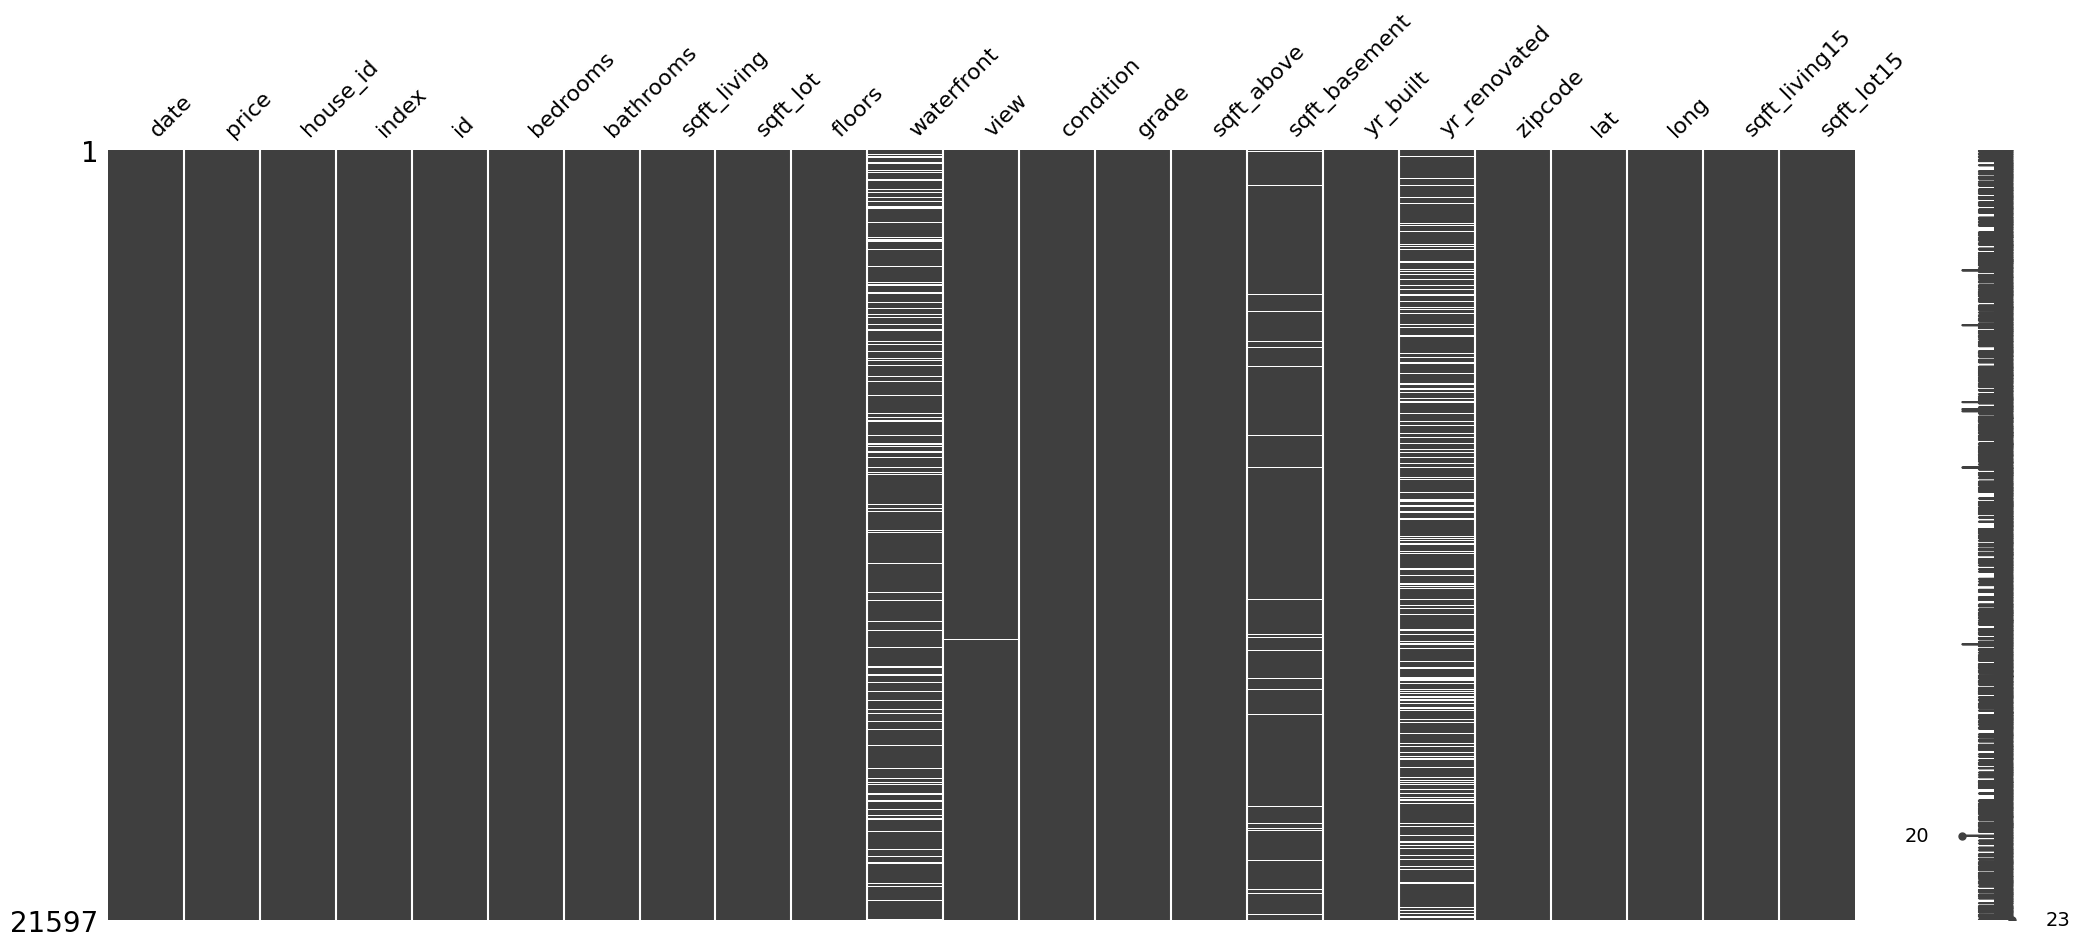

In [73]:
msno.matrix(df)

There seems to be no pattern. We store the dataframe in a new dataframe which we want to clear and use from now on. The split is done to keep original data accessable. 

In [74]:
df_clear = df

We now have to check whether it makes sense to produce syntetic data to fill in the gap or whether there are other ways to fill in the NaNs. 

__Column waterfront:__ It makes no sense to interpolate this value. Also, since our client specifically demands a waterfront, this would be very risky. Recommending a house with syntetic data here could lead to bad quality advise. It is recommended to assume that every house with NaN in waterfront has no waterfront. 

__Column view:__ It is unclear how this value was collected. It could be a subjective impression from the evaluators visit. It could be a criterea defined by the appearence of water and trees or the absense of nearby buildings or industry. In case of a subjective impression it is easier to argue that an interpolation makes sense. Also the amount of NaN is very limited which speaks in favor for an interpolation. Without any further information I would usually decide to set the value to 0 by default for every NaN. But since I want to practise this more, I decide to interpolate in this project. 

__Column sqft_basement:__ This value can be recalculated by the difference of sqrt_living and sqrt_above. 

__Column yr_renovated:__ An interpolation makes little sense here. Also the consequences of a wrong data entry are quite severe. We obstain from synthetic data and set all NaN to default 0. 

In [75]:
df_clear['waterfront'] = df_clear['waterfront'].where(df_clear['waterfront'].notna(), 0)
df_clear['view'] =  df_clear['view'].interpolate()
df_clear['sqft_basement'].fillna(df_clear['sqft_living'] - df_clear['sqft_above'], inplace=True)
df_clear['yr_renovated'] = df_clear['yr_renovated'].where(df_clear['yr_renovated'].notna(), 0)


Now we check whether all NaN are gone: 

In [76]:
error_waterfront_new = round(df_clear['waterfront'].isna().sum()/df_clear['waterfront'].shape[0]*100, 1)
error_view_new = round(df_clear['view'].isna().sum()/df_clear['view'].shape[0]*100, 1)
error_sqft_basement_new = round(df_clear['sqft_basement'].isna().sum()/df_clear['sqft_basement'].shape[0]*100, 1)
error_yr_renovated_new = round(df_clear['yr_renovated'].isna().sum()/df_clear['yr_renovated'].shape[0]*100, 1)
print(f"waterfront: {error_waterfront_new}%, view: {error_view_new}%, sqft_basement: {error_sqft_basement_new}%, yr_renovated: {error_yr_renovated_new}%")

waterfront: 0.0%, view: 0.0%, sqft_basement: 0.0%, yr_renovated: 0.0%


Let's not forget about the change of data type in column yr_renovated since all NaN are gone now. 

In [77]:
df_clear['yr_renovated'] = df_clear['yr_renovated'].astype(int)
type(df_clear['yr_renovated'][13])

numpy.int32

Now we save the dataset and reload: 

In [78]:
df_clear.to_csv('data/data_clear.csv',index=False)
df_clear = pd.read_csv('data/data_clear.csv')

__Exploration__

We want to find out, where people invested money in improving their real estates. So we try to plot where renovations have happened: 

In [79]:
df_clear_renovated = df_clear[(df_clear['yr_renovated'] > 0)]

In [90]:
import plotly.express as px

fig = px.scatter_mapbox(df_clear_renovated, lat="lat", lon="long", 
                        color_discrete_sequence=["blue"], zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=1200, height=800)

fig.show()


As it turns out, there is a lot of money flowing into improving houses in the larger area of Seattle and southern districts. Elsewhere, there is little improvement. 

We remember that there were houses with NaN in column waterfront. We want to find those and check whether it is worth visiting them again to check whether there is really no waterfront as we have filled in the gaps. 

In [89]:
df_clear_waterfrontnan = df_origin[(df_origin['waterfront'].isna())]
import plotly.express as px

fig = px.scatter_mapbox(df_clear_waterfrontnan, lat="lat", lon="long", 
                        color_discrete_sequence=["blue"], zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=1200, height=800)

fig.show()

We could now combine this with a [dataset that holds information](https://geo.wa.gov/datasets/57a2cf1fbc5e434f9113b5cb9dbfb0d6_15/explore?location=47.521910%2C-122.168264%2C11.59) about the areas of waterbodies and then run a query to exclude all houses that are more far away than, let's say 500 meter from a waterbody. Sadly, out imperfect coding skills and the lack of time (tried it for three hours) made this impossible. So, we  on. 

Since it is already a bit late and we run out of serious ideas we now want to know whether we can still see the Great Depression. Since we later not only want to check how many houses are available from that period but also how their prices are, we exclude all houses that have been renovated and whos prices therefore have been 'resetted'. 

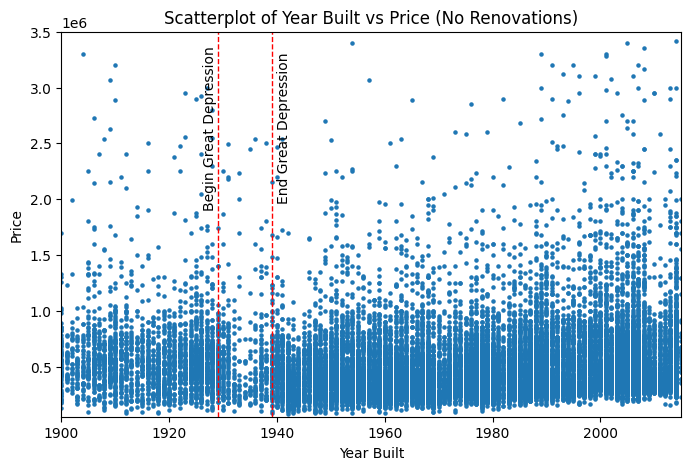

In [321]:
import matplotlib.pyplot as plt

df_greatdepression = df[df['yr_renovated'] == 0]

plt.scatter(df_greatdepression['yr_built'], df_greatdepression['price'], s=5)

plt.title('Scatterplot of Year Built vs Price (No Renovations)')
plt.xlabel('Year Built')
plt.ylabel('Price')

plt.ylim(50000, 3500000)
plt.xlim(1900, 2015)
plt.axvline(x=1929, color='red', linewidth=1, linestyle='--')
plt.axvline(x=1939, color='red', linewidth=1, linestyle='--')
plt.text(.24, 0.75, 'Begin Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)
plt.text(.36, 0.75, 'End Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)


plt.show()


As it turns out, it seems that there are way less real estates for offer compared to the earlier or the later decade. But let's check that out accordingly: 

Let's plot that because I think we can get some valuable insides here. 

In [322]:
df_greatdepression['decade'] = ((df_greatdepression['yr_built'] // 10)) * 10
decade_counts = df_greatdepression.groupby('decade').size()

print(decade_counts)

decade
1900     572
1910     705
1920    1091
1930     458
1940    1639
1950    2320
1960    2578
1970    2244
1980    2262
1990    2229
2000    3514
2010    1241
dtype: int64


In [343]:
decade_medians = df_greatdepression.groupby('decade')['price'].median()

print(decade_medians)


decade
1900   549000.000
1910   505000.000
1920   530100.000
1930   451000.000
1940   379000.000
1950   395000.000
1960   375000.000
1970   435000.000
1980   449975.000
1990   487275.000
2000   496250.000
2010   539950.000
Name: price, dtype: float64


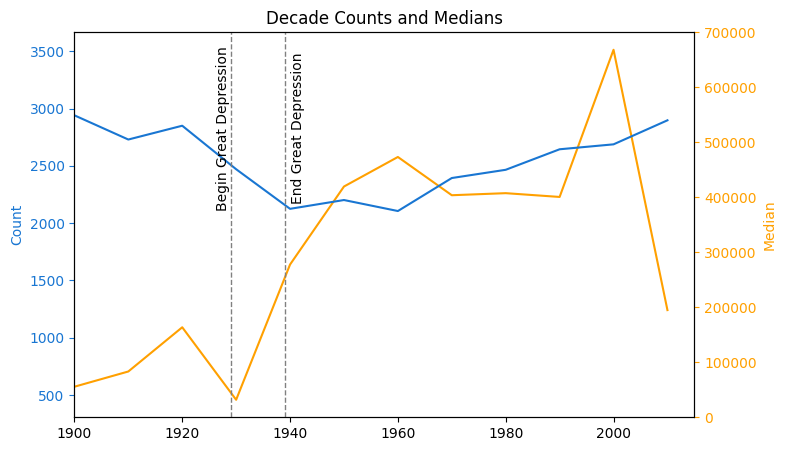

In [353]:
fig, ax1 = plt.subplots()

# Plot the decade counts
ax1.plot(decade_counts.index, decade_counts.values, label='Decade Counts', color='#ffa000')
ax1.set_ylabel('Count', color='#1976d2')
ax1.tick_params('y', colors='#1976d2')

# Create a second axis
ax2 = ax1.twinx()

# Plot the decade means
ax2.plot(decade_medians.index, decade_medians.values, label='Decade Medians', color='#1976d2')
ax2.set_ylabel('Median', color='#ffa000')
ax2.tick_params('y', colors='#ffa000')

# Set the title
ax1.set_title('Decade Counts and Medians')

plt.xlim(1900, 2015)
plt.ylim(0, 700000)

plt.axvline(x=1929, color='gray', linewidth=1, linestyle='--')
plt.axvline(x=1939, color='gray', linewidth=1, linestyle='--')
plt.text(.24, 0.75, 'Begin Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)
plt.text(.36, 0.75, 'End Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()


So, what do we see here? Assuming that the current available houses correlate with the houses built during that episode we can see, that people have built less houses during the crisis. Surprise! Then the crisis hit hard, but afterwards people needed homes. So the numbers rose again very fast. 
What is more interesting is todays median house price from that time. It is way lower for the time of the crisis and is also lower for the decades afterwards. It took them __50 years__ to recover.

But why is it the way it is and what do we learn from this? Well, there are two obvious explanations. First, people had no money after the crisis and therefore decided to buy smaller properties and built smaller houses which are now less valuable. This would be logical and doesn't help us very much. 

__But.__

Explanation #2 says that people had no money and therefore have built houses with low quality material. Like wood, concrete and isolation material. So, their houses might be as big as houses of earlier or later times - but are of lower quality. And therefore their current prices are lower. 

What does this help us? Well, it helps us to be careful about these houses. Whenever we think about buying a house of a time period of the Great Depression and later decades of Kings County we should very closely check whether the material of this real estate is of lower quality. 

To check whether crises houses are just smaller or shabbier we would have to check the value by some messuarements, such as lot size and floor amount. But we would also have to consider other factors like the location and others. So, just a short check, whether we can get a quick answer by jsut lot size and floor amount. 

In [364]:
decade_lots = df_greatdepression.groupby('decade')['sqft_lot'].median()
decade_floors = df_greatdepression.groupby('decade')['floors'].mean()

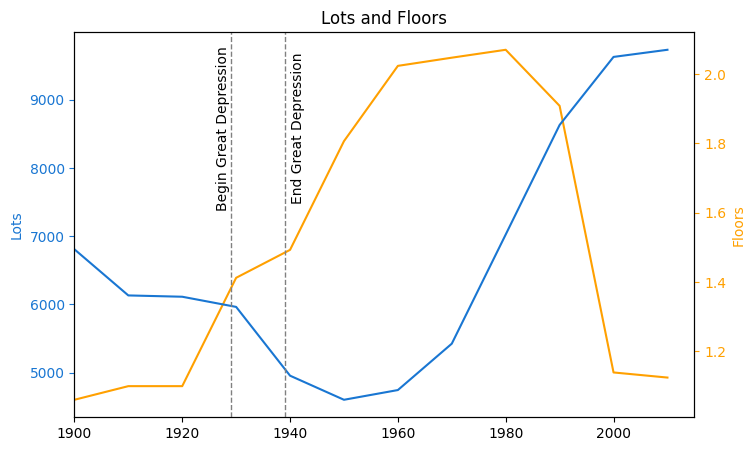

In [366]:
fig, ax1 = plt.subplots()

# Plot the decade counts
ax1.plot(decade_lots.index, decade_lots.values, label='Lots', color='#ffa000')
ax1.set_ylabel('Lots', color='#1976d2')
ax1.tick_params('y', colors='#1976d2')

# Create a second axis
ax2 = ax1.twinx()

# Plot the decade means
ax2.plot(decade_floors.index, decade_floors.values, label='Floors', color='#1976d2')
ax2.set_ylabel('Floors', color='#ffa000')
ax2.tick_params('y', colors='#ffa000')

# Set the title
ax1.set_title('Lots and Floors')

plt.xlim(1900, 2015)


plt.axvline(x=1929, color='gray', linewidth=1, linestyle='--')
plt.axvline(x=1939, color='gray', linewidth=1, linestyle='--')
plt.text(.24, 0.75, 'Begin Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)
plt.text(.36, 0.75, 'End Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()

As we can see people really tend to buy smaller properties for their houses after the crisis. That could explain the current lower price. But! Their houses also rose to greater heights measured by floor amount. This works against the simple argumentation that the lower prices are simply explainable by bigger areas to sell. So, the result is unclear and further analysis is needed to say whether crisis house are a red flag and should be checked for proofs of lower quality. 